In [1]:
%load_ext autoreload
%autoreload 2
import geopandas as gpd
directory = '/scratch/6256481/'


import sys
sys.path.insert(0, directory + f'python/py_code/')
import numpy as np
from support import get_local_utm_projection, node_position, adjust_new_segments
from cycle_identification import find_connected_side
from get_orthogonals import get_orthogonals
from dem import find_dem

from shapely.geometry import Point, LineString

from support import create_dir
from glob import glob
# from python.py_code.old.remove_mannual_add import remove_manual_add, remove_man_add

from line_functions import get_bend_dist_out


import pandas as pd
# from python.py_code.old.reach_def import create_ud_id, create_new_segments

from datetime import datetime as dt
from inflection_points import inflection_points, inflection_points_curve


from connect_geometries import merge_centerlines
from smoothing import SG_smoothing
from tqdm import tqdm

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import xarray as xr
import shapely


In [6]:
singleConfFiles = np.sort(glob(directory + f'results/single_values/*conf.nc'))

In [2]:
c = 'as'
i = '12'

create_new = False
vector_save_file = directory +f'results/new_segments/vector/{c}_{i}_reach_new_segments.gpkg'
node_save_file   = directory +f'results/new_segments/node/{c}_{i}_node_new_segments.gpkg' 

In [3]:
df       = gpd.read_file(vector_save_file)
dfNode   = gpd.read_file(node_save_file)

df = adjust_new_segments(df)

In [ ]:
dfCF = pd.read_csv(directory + 'results/confinement_factor.csv')

In [111]:
dftest  = gpd.read_file(glob.glob(directory + 'input/SWOT_vector/af*.gpkg')[0])
dfNtest = gpd.read_file(glob.glob(directory + 'input/SWOT_nodes/af*.gpkg')[0])

In [8]:
# files = np.sort(glob.glob(directory +f'results/new_segments/vector/??_??_*.gpkg'))

# for i, f in enumerate(files):
#     D = gpd.read_file(f)
#     D['file_cont'] = f[-29:-27]
#     D['file_id']   = f[-26:-24]
    
#     if i == 0:
#         dfT = D.copy()
#     else:
#         dfT = pd.concat([dfT, D], ignore_index = True)
# dfT['file'] = dfT['file_cont'] +'_'+ dfT['file_id']
# dfInc = dfT[dfT['include_flag'] == '0']

In [4]:
def plot(combinedLine, combinedLineSmooth, infP, infPTotal,apexP, apexPO):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize = [10,6], sharey=True)

    ax.plot(*combinedLine.xy      , color = 'orange'   , zorder = 0)
    ax.plot(*combinedLineSmooth.xy, color = 'chocolate', zorder = 10, linestyle = '--')

    # plot inflections
    if isinstance(infP, list):
        for i, ip in enumerate(infP):
            plt.scatter(*ip.xy, zorder = 100, c = 'black', marker = '.')
        for i, ip in enumerate(infPTotal):
            plt.scatter(*ip.xy, zorder = 80, c = 'lime', marker = '.')
    if isinstance(apexP, list):
        for i, ap in enumerate(apexP):
            plt.scatter(*ap.xy, zorder = 100, c = 'red', marker = '^')
            plt.scatter(*apexPO[i].xy, zorder = 100, c = 'red', marker = '1')
            

    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')



    plt.tight_layout()
    plt.show()

def plot_inflection_points_curve(inf, infT, apexP, apexPO, line, lineO):
    plt.figure(figsize=[10,8])
        # plt.scatter(*testApex, label = arcSign[ip], marker = '^', s = 25, zorder = 200, c = 'green')
    # for i in range(len(apexP)):
    #     plt.scatter(*apexP[i].xy , s = 30, marker = 'h', zorder = 150, c = 'red')
    #     plt.scatter(*apexPO[i].xy, s = 30, marker = '1', zorder = 100, c = 'red')

    for i in range(len(inf)):
        plt.scatter(*inf[i]    , s = 30, marker = '.', zorder = 100, c = 'limegreen')
        # plt.scatter(*inf[i]    , s = 20, marker = '.', zorder = 100, label = i) 
    plt.scatter(*inf[i]    , s = 100, marker = '.', zorder = 100, c = 'limegreen')

    for i,p in enumerate(infT):
        plt.scatter(*p    , s = 30, marker = '.', zorder = 50, c = 'black')

    plt.plot(*line.xy , zorder = 10, color = 'blue', linestyle = '--')
    plt.plot(*lineO.xy, zorder = 5 , color = 'cyan', linestyle = '-')
    plt.axis('equal')
    plt.axis('off')
    # plt.legend()
    plt.show()


In [29]:
int(df[df['reach_id'] == 45254000391]['combined_reach_id'].iloc[0])
# df.iloc[0:10].combined_reach_id.values

48203

In [11]:
df[df['combined_reach_id'] == 48126]['reach_id'].values

array([45253001001, 45253001011, 45253001021, 45253001031, 45253001041])

  0%|          | 0/7 [00:00<?, ?it/s]

0 1   0   0  
0.0, 264.0, 592.9705158598152, 592.9705158598154
1 1   0   0  
1.1641532182693481e-10, 264.0, 700.7833369256807, 700.7833369256807
2 1   0   0  
101.55220024713228, 265.375, 2438.530684750637, 2426.198020119873
3 2   -1  0  
189.37591840173923, 252.55, 3965.6295260490774, 3941.1847907657047
4 2   0   0  
0.1674113425469942, 258.0, 260.1314051579404, 260.13105494861117
5 4   1   1  
402.9431115991107, 298.1842105263158, 3827.404783427912, 3712.7913811391536
6 4   0   0  
0.8372108995039853, 573.5, 228.0466808984345, 228.03989554121355
7 4   0   0  
1.269011793336868, 541.6666666666666, 564.3497430372398, 564.3290906934104
8 4   0   0  
1.606804648603734, 543.7, 903.6875358828719, 903.6473440324895
9 4   0   0  
4.292241483933142, 543.7, 1077.120624847216, 1077.050105023658
10 4   0   0  
5.3845238357279275, 529.1666666666666, 1242.4483118819858, 1242.369405423224
11 4   0   0  
7.2844229902471795, 545.125, 1666.037999875696, 1665.9441904638893
12 4   0   0  
215.5973069874

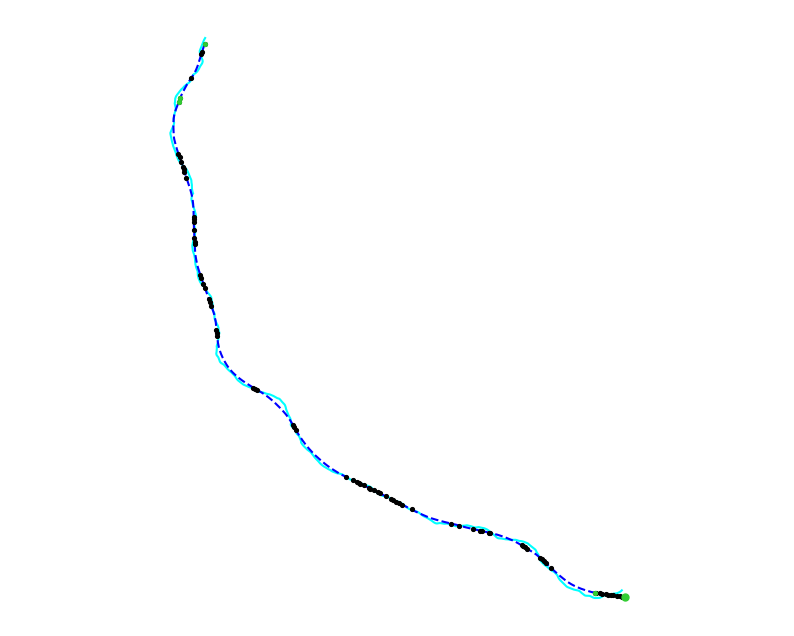

 14%|█▍        | 1/7 [00:01<00:10,  1.67s/it]

53800.79199286671 [ 3965.62952605   260.13140516 47558.86514105  2016.16592061]
0 1   0   0  
0.0, 84.0, 47.51987815847757, 47.51987815847757
1 1   0   0  
5.820766091346741e-10, 84.0, 142.55963447639718, 142.55963447639718
2 2   -1  -1 
388.6191462617146, 72.5, 1062.088277668117, 670.7388265409074
3 3   1   1  
218.32572252912888, 87.6, 979.5003843358654, 867.735592615487
4 3   0   0  
1.7142888457747179, 92.0, 141.47046988586877, 141.4285713839345
5 3   1   1  
191.87415686315111, 96.91666666666667, 1183.0199636664256, 1103.4701689889084
6 4   -1  -1 
166.83760319371504, 83.0, 537.5287025471741, 377.55175616047234
7 5   1   1  
242.13013820478776, 57.5, 706.1127903648477, 425.5480328468033
8 6   -1  -1 
183.8638598999611, 75.625, 775.2824472013469, 654.5147571620008
9 7   1   1  
243.0160421476933, 82.6, 1089.5028919279957, 910.5084751054123
10 7   0   0  
34.801676787227606, 71.5, 426.9283605022714, 420.0016581457969
11 8   -1  0  
56.34883652387242, 78.7, 884.2692991109585, 869.070

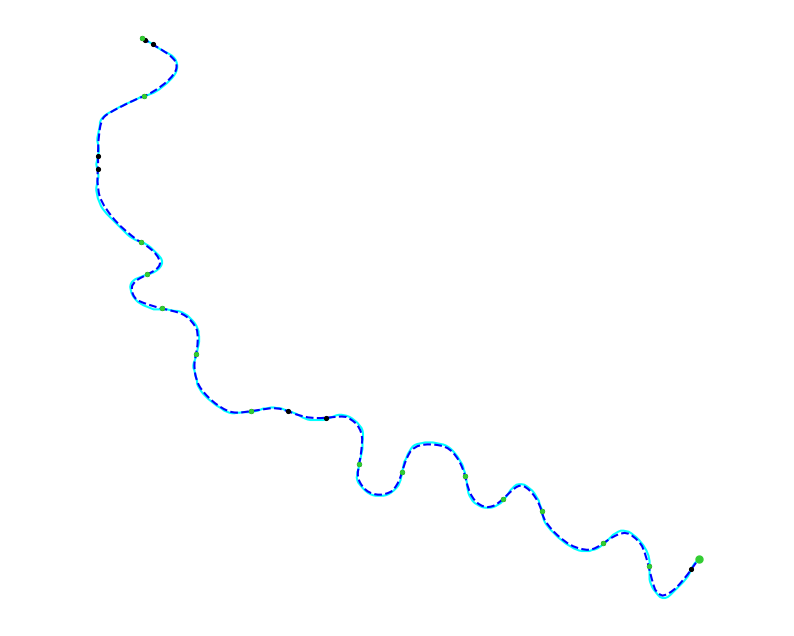

 29%|██▊       | 2/7 [00:02<00:05,  1.04s/it]

14104.341127660506 [1062.08827767 2162.520348    537.52870255  706.11279036  775.2824472
 1089.50289193 1739.04656697  896.30903439 1100.66427244  683.61402854
  642.43869059  930.73248942  777.88270227 1000.61788533]
0 1   -1  -1 
33.54995642770961, 45.0, 187.31976296705432, 171.20765827622674
1 2   -1  1  
60.63934283578214, 45.0, 757.2230146084262, 716.8295307232903
2 2   0   0  
7.191880079777967, 42.0, 160.41516184135205, 159.62472769125884
3 2   0   0  
12.507469430821086, 42.0, 330.8070911895969, 329.0838980271976
4 2   -1  -1 
38.20871547987637, 52.5, 823.7156782074945, 816.1502176322705
5 2   0   0  
6.488985789975947, 42.0, 200.92140027373674, 200.3398089102939
6 2   -1  0  
28.722982674752355, 50.0, 541.097558664787, 536.1569104763929
7 2   0   0  
13.39734319560167, 42.0, 301.2944486450074, 300.0599943761198
8 2   -1  -1 
40.163844491451535, 45.0, 652.3874627677957, 640.3780153950654
9 3   1   1  
165.12132161959525, 55.5, 869.1305727002409, 786.3080084114762
10 3   0   0  

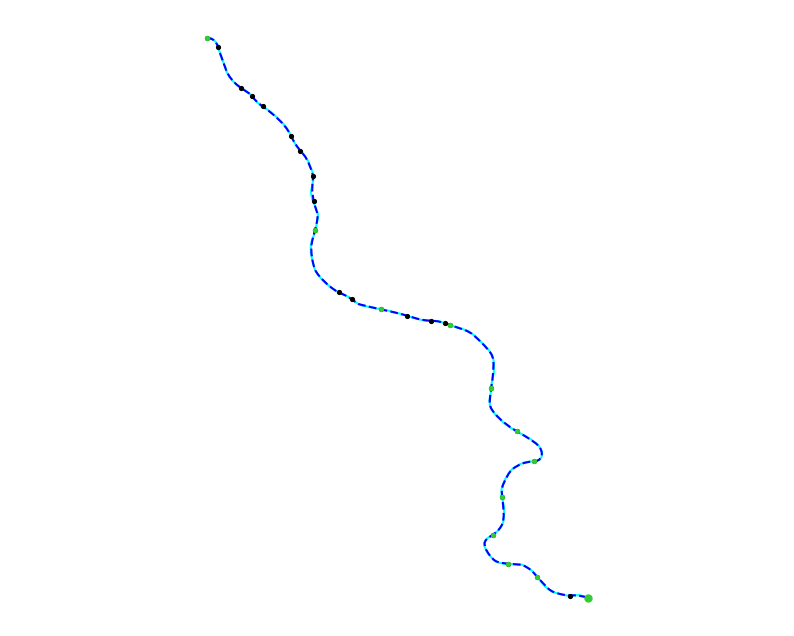

 43%|████▎     | 3/7 [00:02<00:03,  1.24it/s]

10015.129087967724 [2774.42371425 1414.96305963  833.45736034 1016.99565612  656.39644604
  559.68043477  635.96522992  488.01810261  556.86290086  391.80936437
  686.55681907]
0 1   0   0  
0.0, 92.0, 45.14969354696633, 45.14969354696633
1 1   0   0  
1.1641532182693481e-10, 92.0, 316.04785482745666, 316.04785482745666
2 1   0   0  
1.1641532182693481e-10, 83.5, 406.34724192091244, 406.34724192091255
3 1   0   0  
1.1641532182693481e-10, 83.5, 451.4969354674429, 451.49693546744294
4 1   0   0  
1.1641532182693481e-10, 83.5, 541.7963225613755, 541.7963225613756
5 1   0   0  
1.1641532182693481e-10, 84.5, 948.143564481893, 948.1435644818932
6 1   0   0  
1.1641532182693481e-10, 84.4, 993.2932580288184, 993.2932580288186
7 1   0   0  
1.1641532182693481e-10, 84.4, 1038.4429515753488, 1038.442951575349
8 1   0   0  
2.3283064365386963e-10, 84.4, 1128.7423386692815, 1128.7423386692817
9 1   0   0  
1.1641532182693481e-10, 78.85714285714286, 1580.2392741367653, 1580.2392741367657
10 1   0  

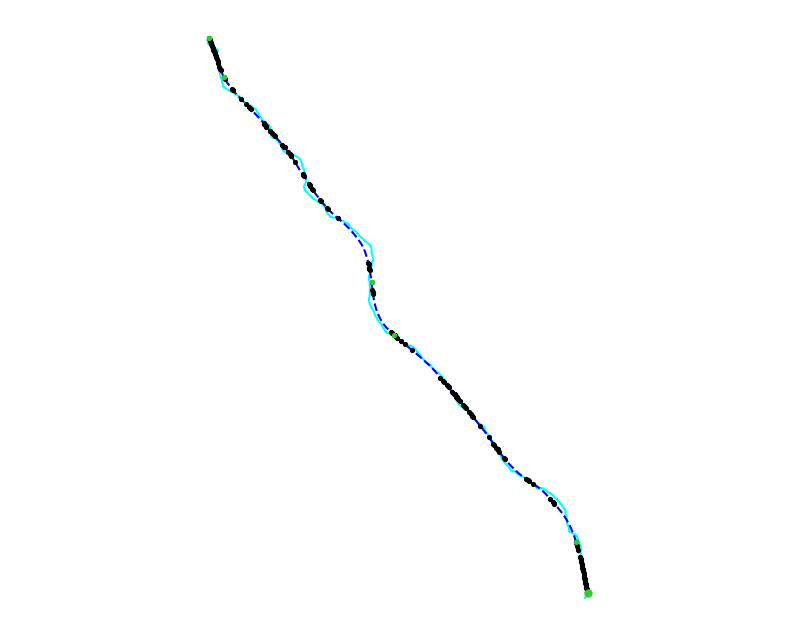

 57%|█████▋    | 4/7 [00:08<00:07,  2.64s/it]

127183.29636923414 [ 7776.39446041 47392.27685178 10801.99023887 51404.28751539
  9808.34730279]
0 1   0   0  
0.0, 17372.0, 85.39908112220569, 85.39908112220567
1 1   0   0  
0.0, 17372.0, 256.1972433667298, 256.1972433667299
2 1   0   0  
4.799926683327254e-10, 17372.0, 426.9954056113685, 426.9954056113686
3 1   0   0  
0.0, 17372.0, 512.394486733687, 512.3944867336871
4 1   0   0  
4.799926683327254e-10, 17372.0, 768.5917301004168, 768.591730100417
5 1   0   0  
4.799926683327254e-10, 17372.0, 939.3898923450556, 939.3898923450556
6 1   0   0  
4.799926683327254e-10, 17372.0, 1280.986216833991, 1280.9862168339912
7 1   0   0  
4.799926683327254e-10, 17372.0, 1451.7843790786296, 1451.7843790786299
8 1   0   0  
4.799926683327254e-10, 17372.0, 1793.3807035676778, 1793.3807035676782
9 1   0   0  
4.799926683327254e-10, 17372.0, 1964.1788658123164, 1964.178865812317
10 1   0   0  
4.799926683327254e-10, 17372.0, 2391.17427142357, 2391.174271423571
11 1   0   0  
4.799926683327254e-10, 17

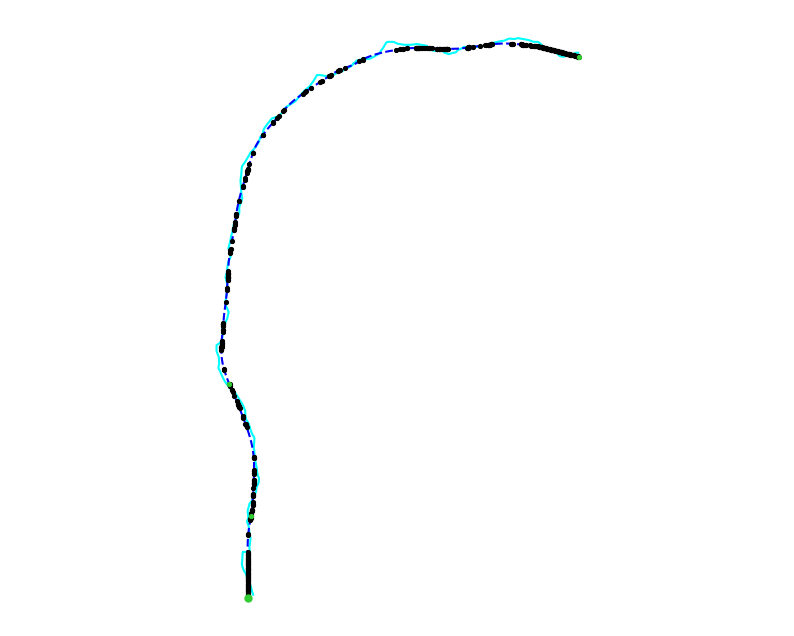

 71%|███████▏  | 5/7 [00:41<00:27, 13.56s/it]

399637.5022263885 [293262.07594299  66396.75677636  39978.66950704]
0 1   0   0  
2.9103830456733704e-11, 63.0, 24.561211105092283, 24.561211105092283
1 1   0   0  
5.820766091346741e-11, 63.0, 49.12242220973304, 49.12242220973303
2 1   0   0  
8.305744159397966, 63.0, 199.40640295266732, 198.44958361895596
3 2   1   1  
205.91778297033198, 56.833333333333336, 741.6358129284038, 588.7521258904484
4 3   -1  -1 
42.84450693928513, 51.666666666666664, 420.66952537361556, 408.0843706459443
5 4   1   1  
39.43493067761087, 45.4, 1168.8470557179428, 1163.8420860019432
6 4   0   0  
1.0262268532902032, 54.5, 270.50399959660905, 270.49375289659105
7 4   0   0  
1.4773304220603594, 54.5, 336.5491884907445, 336.5253437128357
8 4   0   0  
27.15430094645027, 74.5, 678.2589884771523, 674.7802487123506
9 5   -1  0  
51.149881847261405, 81.2, 852.3019240535269, 845.3539654883718
10 5   -1  -1 
111.31757762546624, 74.2, 1029.1374505965036, 993.6412119933824
11 6   1   1  
223.02391868442362, 60.75, 7

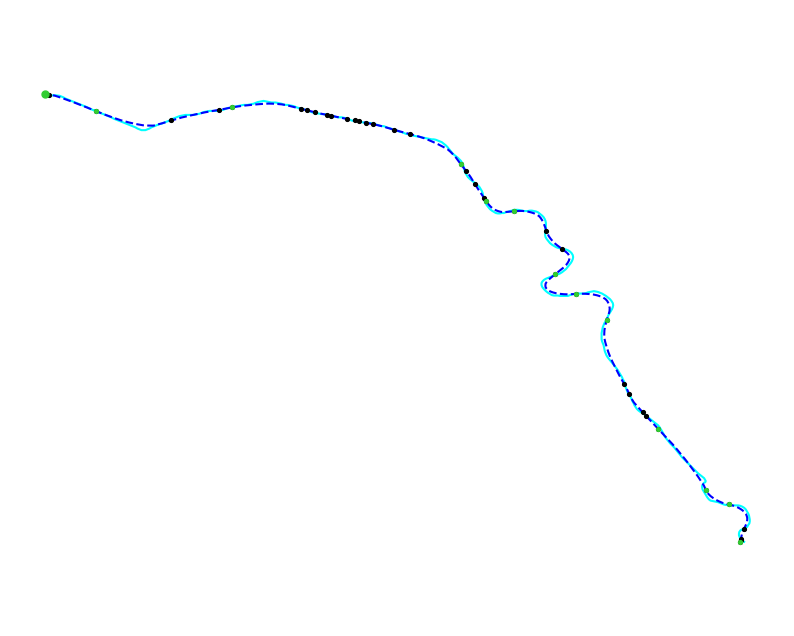

 86%|████████▌ | 6/7 [00:41<00:09,  9.22s/it]

14955.771254966168 [ 741.63581293  420.66952537 1168.84705572 1881.43937465  786.49481499
  750.64592294 1515.12201347  484.48326249  671.98382494 3633.00485639
 2088.27321118  813.1715799 ]
0 1   0   0  
0.0, 514.0, 119.6114296509156, 119.6114296509156
1 1   0   0  
0.0, 536.0, 358.83428895275904, 358.834288952759
2 1   0   0  
1.1641532182693481e-10, 537.3333333333334, 598.0571482550533, 598.0571482550533
3 1   0   0  
1.1641532182693481e-10, 530.6, 956.8914372078124, 956.8914372078123
4 1   0   0  
5.81619920182981, 541.875, 1570.4175098921896, 1570.3144851249328
5 2   1   0  
374.1649520003562, 606.6842105263158, 3915.2589695735337, 3799.0463525875493
6 2   0   0  
0.26420862339836265, 691.5, 164.01327966784964, 164.01242843425786
7 2   0   0  
7.206267459126404, 670.25, 766.3122689741996, 766.1570442777258
8 4   -1  -1 
1095.9077002099143, 563.8227144877116, 4904.986400092246, 3664.8654994848366
9 4   0   0  
81.17765971254411, 208.47886657714844, 919.98154793457, 900.578191562542

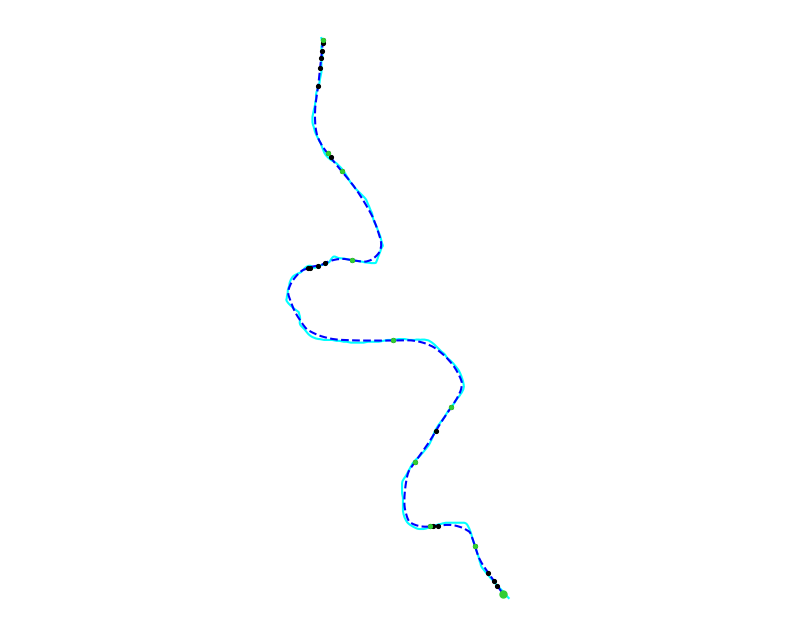

100%|██████████| 7/7 [00:42<00:00,  6.09s/it]

28430.493180519377 [3915.25896957  766.31226897 4138.67413112 6985.38813875 3852.09564977
 2207.90001169 2830.51346151 1888.44710219 1845.90344694]


In [30]:
minLenFactor = 4*12

ids = df.loc[df['include_flag'] == '0','combined_reach_id'].unique()
ids = [12722, 12733, 12742, 12754,12806, 12805]
ids = [12983, 13042, 13100, 13140, 13181, 13218, 12721., 12720., 12719., 12718., 12717., 12716., 12715.,
       12714., 15800]
ids = [15800]
ids = [48126, 48162, 48160, 48142, 45610, 48278, 48203]
# ids = [48167]


dfSF = pd.read_csv(directory + 'results/smoothingFactor.csv')

for id in tqdm(ids):
        # print(id, fac)
        dfReach      = df[df['combined_reach_id'] == id].copy()
        dfReachNodes = dfNode[dfNode['reach_id'].isin(dfReach['reach_id'].values)].copy()


        dfReach.loc[dfReach['max_width'] < dfReach['width'], 'max_width']                = dfReach['width']
        dfReachNodes.loc[dfReachNodes['max_width'] < dfReachNodes['width'], 'max_width'] = dfReachNodes['width']

        GroupedCRS = dfReach.groupby('localCRS', as_index = False).size()
        reachCRS   = GroupedCRS.loc[GroupedCRS['size'] == GroupedCRS['size'].max()
                                    ,'localCRS'].iloc[0]
        
        dfReach      = dfReach.to_crs(reachCRS)
        dfReachNodes = dfReachNodes.to_crs(reachCRS)

        combinedLine, _, _ = merge_centerlines(dfReach, df, reachCRS)
        
        dfReachNodes = node_position(combinedLine, dfReachNodes)
        
        groupVals = dfReach.iloc[0]
        maxWidth = groupVals['combined_reach_max_width']
        width    = groupVals['combined_reach_width']
        
        if np.isnan(maxWidth):
                maxWidth = dfReachNodes['max_width'].mean()


        reachLen = groupVals['combined_reach_len']
        
        factorWidth = width
        minLen      = minLenFactor * maxWidth
        ###########################
        # Smoothing
        ###########################
        factorRow       = abs(dfSF['combined_reach_width'] - width).argsort()
        smoothingFactor = dfSF.loc[factorRow, 'smoothFactor'].iloc[0]

        smoothing_window = smoothingFactor*int(maxWidth)         # Smoothing window based on mean node max width

        combinedLineSmooth = SG_smoothing(combinedLine, smoothing_window, maxWidth)

 
        if len(combinedLineSmooth.coords) < 3:
            combinedLineSmooth = combinedLineSmooth.segmentize(400) 

        # dt1 = dt.now()
        # (sin, infP, infPTotal,
        #     apex, apexP,apexPO,
        #     ang, bendLines, bendWidths, bendMaxWidths, bendDO) = inflection_points(combinedLineSmooth, 
        #                                 dfReach, dfReachNodes,
        #                                 reachCRS,
        #                                 degree = 0,
        #                                 end_points = True)  
        # dt2 = dt.now()
        # print('oldMethod: ', dt2 - dt1)
        # checkLines.append(combinedLineSmooth)

        # apex      = np.array2string(apex, separator = ', ')
        # ang       = np.array2string(ang, separator = ', ')

        # apexP_wkt         = str([I.wkt for I in apexP.copy()])
        # infP_wkt          = str([I.wkt for I in infP.copy()])
        # bendLines_wkt     = str([I.wkt for I in bendLines.copy()])
        # bendWidths_str    = np.array2string(bendWidths, separator = ', ')
        # bendMaxWidths_str = np.array2string(bendMaxWidths, separator = ', ')
        # calculated = '0'


        # plot(combinedLine, combinedLineSmooth, infP, infPTotal,apexP, apexPO)
        # print(sin)
        dt1 = dt.now()
        (sin, bendSin,inf, infT, amplitudes, apexPList, apexPOList, curveList, bendLines, 
                infLines,bendWidths, bendMaxWidths, bendDO, bendLen) = inflection_points_curve(combinedLineSmooth, dfReach, dfReachNodes)
        dt2 = dt.now()
        # print('newMethod: ', dt2 - dt1)
        plot_inflection_points_curve(inf,infT, apexPList, apexPOList, combinedLineSmooth, combinedLine)
        print(combinedLineSmooth.length, bendLen)
        # print()
        
        # print()

In [21]:
inf

[array([ 687052.4491946 , 2965965.72979291]),
 [685434.4627208951, 2962371.9772519246],
 [685340.4241026973, 2962129.438793044],
 [712959.8198135053, 2929513.159325453],
 array([ 714953.14183605, 2929210.51707157])]